### Step 2.1: Data preprocessing

__Step goals:__ Prepare the data for future exploration and modeling. 

__Step overview:__
1. Load the following data sets: city geometry, station geometry, ridership and population;
2. Merge them;
3. Construct Voronoi cells and assign population to these cells.

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os
from shapely.geometry import Point, Polygon, box, shape
from scipy import spatial
from tqdm import tqdm
import numpy as np

#### 1. Load the data

##### a). London geometry

In [141]:
# Load London district and neighborhood borders
borders = gpd.read_file("../data/raw/geometry/london/statistical-gis-boundaries-london/ESRI/OA_2011_London_gen_MHW.shp")
borders.to_crs(epsg='4326', inplace=True)

# Load London border
border = gpd.read_file("../data/raw/geometry/london_simplified/london.shp")
border.to_crs(epsg='4326', inplace=True)

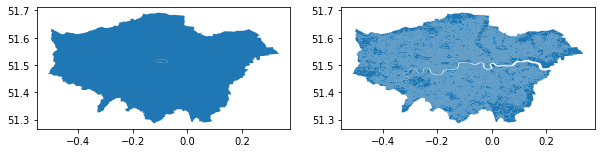

In [142]:
fig, ax = plt.subplots(ncols=2, figsize=(10,8))
border.plot(ax=ax[0])
borders.plot(ax=ax[1]);

##### b). Station geometry

In [29]:
# Load stations geometry
stations = gpd.read_file("../data/processed/geometry/metro_stations/stations_mod.shp")

# Remove some symbols from the station name
stations["Name"] = (
    stations["Name"]
    .str.replace("\t", "")
    .str.replace("\n", "")
    .str.replace(" Station", "")
)
stations = stations.rename({"Name": "station_name"}, axis=1)
stations.to_crs(epsg='4326', inplace=True)

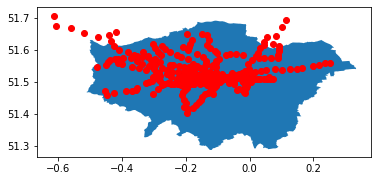

In [36]:
ax = border.plot()
stations.plot(color='red', ax=ax);

##### c). Ridership

In [37]:
# The first 6 rows have irrelevant information
# The format of both data sets is the same
entry_raw = pd.read_csv("../data/processed/counts/En17week.csv", skiprows=6)
exit_raw = pd.read_csv("../data/processed/counts/Ex17week.csv", skiprows=6)

# Select only the "hours" columns and drop the rest
entry = entry_raw.iloc[:, 1:100]
entry["Total"] = entry_raw[" Total"]
entry = entry.drop([" Date", " Note"], axis=1)

# Rename the column for the sake of convenience
entry = entry.rename({" Station": "station_name"}, axis=1)
entry = entry.rename({"Total" : 'total'}, axis=1)

# Repeat the same operations for exit data
exit = exit_raw.iloc[:, 1:100]
exit["Total"] = exit_raw[" Total"]
exit = exit.drop([" Date", " Note"], axis=1)
exit = exit.rename({" Station": "station_name"}, axis=1)
entry = entry.rename({"Total" : 'total'}, axis=1)

# Define the directory to store the data
data_path = "../data/processed/counts/"

# Create it if needed
if not os.path.exists(data_path):
    os.makedirs(data_path)
    print(f"Successfully created the directory {data_path}")

# Save the data
entry.to_csv("../data/processed/counts/entry.csv", index=False)
exit.to_csv("../data/processed/counts/exit.csv", index=False)

##### d). Population

In [38]:
%%time
# Load population data
population = pd.read_excel("../data/raw/population/SAPE20DT10a-mid-2017-coa-unformatted-syoa-estimates-london.xlsx", 
                           sheet_name="Mid-2017 Persons", skiprows=4)  # the first 4 rows have irrelevant information, so skip them

# Rename the columns
population = population.rename({"All Ages": "total_population"}, axis=1)

# Select only the age groups of interest
# The assumption is that only those people who are from the age of 18 to the age of 65 are working
age_groups = [age for age in range(18, 65)]

# Create adult population column
population["adult_population"] = population[age_groups].sum(axis=1)

Wall time: 1min 4s


#### 2. Merge the data

##### a). Population and London geometry

In [39]:
# Merge geometry and population data, both boroughs and wards
density_map = pd.merge(borders, population[["OA11CD", "total_population", "adult_population"]], on="OA11CD")
density_map["density_actual"] = (density_map["total_population"] / density_map.area * 1000000)
                                 
boroughs = density_map.dissolve("LAD11NM", aggfunc="sum", as_index=False)
boroughs["density_actual"] = boroughs["total_population"] / boroughs.area * 1000000
                                 
wards = density_map.dissolve("WD11CD_BF", aggfunc="sum", as_index=False)
wards["density_actual"] = wards["total_population"] / wards.area * 1000000
                                 
# Define the directory to store the data
data_path = "../data/processed/population/"

# Create it if needed
if not os.path.exists(data_path):
    os.makedirs(data_path)
    print("Successfully created the directory %s " % data_path)

# Save the data
boroughs.to_file('../data/processed/population/boroughs.json', driver='GeoJSON')
wards.to_file('../data/processed/population/wards.json', driver='GeoJSON')

##### b). Station geometry and ridership

In [9]:
# Merge entrances/exits data with the station loactions
entry_station = pd.merge(stations, entry, on="station_name")
exit_station = pd.merge(stations, exit, on="station_name")

# Adjust CRS to store the data as JSON files
entry_station.to_crs(epsg=4326, inplace=True)
exit_station.to_crs(epsg=4326, inplace=True)

# Save the data
entry_station.to_file("../data/processed/counts/entry_station.json", driver="GeoJSON")
exit_station.to_file("../data/processed/counts/exit_station.json", driver="GeoJSON")

In [41]:
print(entry_station.shape, exit_station.shape)
print('Note, we manually adjusted station names! We will not use these data files.')

(256, 109) (256, 109)
Note, we manually adjusted station names! We will not use these data files.


#### 3. Construct Voronoi

Construct Voronoi cells based on station geometry

In [2]:
np.random.seed(12345)

In [16]:
stations = gpd.read_file('../data/interim/exit_station.json')
print(stations.shape)
n = stations.shape[0]
stations.crs = {'init': 'epsg:4326', 'no_defs': True}

border = gpd.read_file("../data/raw/geometry/london_simplified/london.shp")
border.to_crs(epsg='4326', inplace=True)

wards = gpd.read_file('../data/processed/population/wards.json')

(264, 99)


IMPORTANT! The construction of Voronoi cells is very much EPSG dependent! If you keep 4326, the resulting Voronoi will be different / more disconnected.

In [17]:
stations = stations.to_crs(epsg=3857)
border = border.to_crs(epsg=3857)
wards = wards.to_crs(epsg=3857)

In [18]:
# Define Voronoi
x = stations.geometry.x
y = stations.geometry.y
coords = list(zip(x, y))
voronoi = spatial.Voronoi(coords)

# Convert Voronoi cells to Shapely polygons
stations["cell"] = None
for i, idx_region in enumerate(voronoi.point_region):
    region = voronoi.regions[idx_region]
    cell_coords = [Point(voronoi.vertices[idx_point]) for idx_point in region]
    cell = Polygon([[p.x, p.y] for p in cell_coords])
    stations.loc[i, "cell"] = cell

In [19]:
# Stations with Vornoi cell as geometry
# Some parts of London are not covered. Some stations with the area also were dropped out. 
total_bounds = border.total_bounds
b = box(total_bounds[0], total_bounds[1], total_bounds[2], total_bounds[3])
stations['lat'] = stations.to_crs(epsg=4326).geometry.y
stations['lon'] = stations.to_crs(epsg=4326).geometry.x
stations = stations.set_geometry("cell").loc[stations.set_geometry("cell").within(b)]
print(n - stations.shape[0], "stations were excluded.")
print(n, stations.shape[0])

23 stations were excluded.
264 241


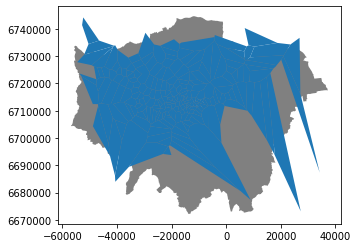

In [20]:
ax = border.plot(color='grey')
stations.plot(ax=ax);

Assigning ward population to Voronoi cells. The assumption here is that population is evenly distributed across the ward. The assignment will be done based on the intersection of Voronoi cell with _n_ wards. The population of a Voronoi cell is equal to population of the wards that it includes.  

In [21]:
stations["adult_population"] = 0
stations.reset_index(drop=True, inplace=True)

In [22]:
voronoi_polygons = [shape(polygon) for polygon in stations["cell"].tolist()]
ward_polygons = [shape(polygon) for polygon in wards["geometry"].tolist()]

intersect_list = []

for i, voronoi_polygon in tqdm(enumerate(voronoi_polygons), total=len(voronoi_polygons)):
    for j, ward_polygon in enumerate(ward_polygons):
        if voronoi_polygon.intersects(ward_polygon):
            intersect = (voronoi_polygon.intersection(ward_polygon).area / voronoi_polygon.area)
            stations.loc[i, "adult_population"] += (wards.loc[j, "adult_population"] * intersect)

100%|███████████████████████████████████████████████████████████████████████████████| 241/241 [00:01<00:00, 145.82it/s]


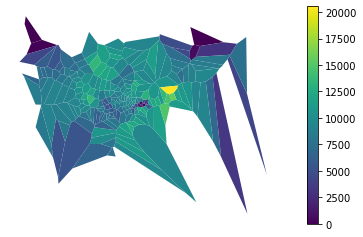

In [23]:
stations.plot(column='adult_population', legend=True, figsize=(10,4))
plt.axis('off');
# plt.savefig('../reports/figures/sn12.png', dpi=300)

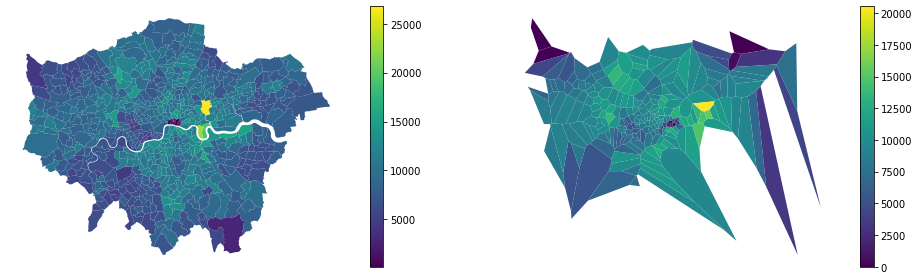

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 4))
wards.to_crs(epsg=3857).plot(column='adult_population', legend=True, ax=ax[0])
stations.to_crs(epsg=3857).plot(column='adult_population', legend=True, ax=ax[1])
ax[0].axis('off');
ax[1].axis('off');
fig.tight_layout()
# plt.savefig('../reports/figures/sn11.png', dpi=300)

In [25]:
# Save the result
stations.drop("geometry", axis=1).set_geometry("cell").to_file("../data/processed/counts/exit_voronoi.json", driver="GeoJSON")